# Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce

import re

import missingno as msno  

# Importing & Organizing Data

In [8]:
## Takes a dataframe with a "FIPS County" code and translates it into an object
## This is done because the csv saves codes such as 01001 as 1001
def fips_to_obj(df):
    df['FIPS'] = [int(i) for i in df['FIPS'].fillna(0)]
    df['FIPS'] = df['FIPS'].astype('object')
    fips_list = []
    for i in df['FIPS']:
        if len(str(i)) < 5:
            fips_list.append('0' + str(i))
        else:
            fips_list.append(str(i))
    df['FIPS'] = fips_list
    return df

In [3]:
# Importing Excel file data from USDA Food Atlas 
book_usda = pd.read_excel('../data/imports/usda_food_atlas//USDA-Food-Atlas.xls', sheet_name=None)

## Death from Strokes Rate
Taken from Center for Disease Control and Prevention (2014 - 2016)

Source: https://www.cdc.gov/dhdsp/maps/national_maps/stroke_all.htm

In [4]:
## Importing target data
strokes = pd.read_csv('../data/imports/stroke_deaths/stroke_all.csv')

## Renaming for readability
strokes.rename(columns={
    'FIPS code' : 'FIPS',
    'Adults 35+' : 'strokeDeath_rate'
}, inplace=True)

## Correcting FIPS County errors
strokes = fips_to_obj(strokes)

## Storing only the data needed
df_strokes = strokes[['FIPS','strokeDeath_rate']]

## Average Life Expectancy
Taken from Center for Disease Control and Prevention (updated 2010)

Source: https://healthdata.gov/dataset/community-health-status-indicators-chsi-combat-obesity-heart-disease-and-cancer

In [7]:
## Importing target data
avgLifeExpec = pd.read_excel('../data/imports/life_expectancy/CHSI DataSet.xlsx',
                                  sheet_name='SUMMARYMEASURESOFHEALTH')

## Renaming for future readability 
avgLifeExpec.rename(columns={
    'ALE' : 'avgLifeExpec'
}, inplace=True)

## Custom FIPS County correction because CDC data was stored with separate County and State columns
county_FIPS = []
for code in avgLifeExpec['County_FIPS_Code']:
    if len(str(code)) < 2:
        county_FIPS.append('00' + str(code))
    elif len(str(code)) < 3:
        county_FIPS.append('0' + str(code))
    else:
        county_FIPS.append(str(code))

avgLifeExpec['FIPS'] = [str(state) + county for county, state in zip(county_FIPS, \
                                                     avgLifeExpec['State_FIPS_Code'])]
avgLifeExpec = fips_to_obj(avgLifeExpec)

## Storing only the data needed
df_avgLifeExpec = avgLifeExpec[['FIPS', 'avgLifeExpec']]

## Land Area
(2010 US Census)

In [11]:
## Importing feature data
land_area = pd.read_csv('../data/imports/land_area/'\
                        'DEC_10_SF1_GCTPH1.US05PR/DEC_10_SF1_GCTPH1.US05PR_with_ann.csv')

## Renaming for future readability 
land_area.rename(columns={
    'Target Geo Id2' : 'FIPS',
    'Area in square miles - Total area' : 'totalArea',
    'Area in square miles - Land area' : 'landArea',
    'Housing units' : 'housingUnits'
}, inplace=True)

## Some cells had multiple values in it. The following code cleans up the ones in parentheses
## NOTE: Although this data was not used, it may be better to remove the values outside the parentheses instead
houseUnits = []
for i in land_area['housingUnits']:
    houseUnits.append(re.sub('\([^\)]+\)','',i)) ## Removes housing unit value inside parentheses
land_area['housingUnits'] = houseUnits
land_area['housingUnits'] = land_area['housingUnits'].astype('int')

## Correcting FIPS County errors
land_area = fips_to_obj(land_area)

## Removing state-wide data so that only FIPS County data remains
mask = [len(i) < 5 for i in land_area['FIPS']]
land_area.drop(index=land_area[mask].index, inplace=True)

## Storing only the data needed
df_land_area = land_area[['FIPS','totalArea','landArea','housingUnits']]

## Transportation Means 
(American Community Survey: 2017 5 year estimates)

In [17]:
## Importing  data
transportation = pd.read_csv('../data/imports/transportation/ACS_17_5YR_B08534_with_ann.csv')

## Renaming for readability
transportation.rename(columns={
    'Id2' : 'FIPS',
    'Estimate; Total:' : 'totalPop',
    'Estimate; Total: - Car, truck, or van:' : 'carTruckVan',
    'Estimate; Total: - Public transportation (excluding taxicab):' : 'pubTran',
    'Estimate; Total: - Public transportation (excluding taxicab): - Bus or trolley bus:' : 'pubTran_bus',
    'Estimate; Total: - Public transportation (excluding taxicab): - Streetcar or trolley car (carro '\
    'publico in Puerto Rico), subway or elevated:' : 'pubTran_streetcar',
    'Estimate; Total: - Public transportation (excluding taxicab): - Railroad or ferryboat:'\
    : 'pubTran_trainFerry',
    'Estimate; Total: - Walked:' : 'walk',
    'Estimate; Total: - Taxicab, motorcycle, bicycle, or other means:' : 'taxiMotoBikeOther',
}, inplace=True)

transportation['pct_carTruckVan'] = transportation['carTruckVan'] / transportation['totalPop']
transportation['pct_pubTran'] = transportation['pubTran'] / transportation['totalPop']
transportation['pct_pubTran_bus'] = transportation['pubTran_bus'] / transportation['totalPop']
transportation['pct_pubTran_streetcar'] = transportation['pubTran_streetcar'] / transportation['totalPop']
transportation['pct_pubTran_trainFerry'] = transportation['pubTran_trainFerry'] / transportation['totalPop']
transportation['pct_walked'] = transportation['walk'] / transportation['totalPop']
transportation['pct_taxiMotoBikeOther'] = transportation['taxiMotoBikeOther'] / transportation['totalPop']

## Correcting FIPS County errors
transportation = fips_to_obj(transportation)

## Storing only the data needed
df_transportation = transportation[['FIPS','pct_carTruckVan','pct_pubTran','pct_pubTran_bus',\
    'pct_pubTran_streetcar','pct_pubTran_trainFerry','pct_walked','pct_taxiMotoBikeOther']]

### Gini Coefficient (Income Inequality)
(American Community Survey: 2017 5 year estimates)

In [19]:
## Importing feature data
gini = pd.read_csv('../data/imports/gini/ACS_17_5YR_B19083_with_ann.csv')

## Renaming for readability
gini = gini.rename(columns={
    'Id2' : 'FIPS',
    'Estimate; Gini Index' : 'Gini_Estimate'})

## Correcting FIPS County Error
gini = fips_to_obj(gini)

## Storing only the data needed
df_gini = gini[['FIPS','Gini_Estimate']]

## Natural Environment
(USDA Economic Research Service)

Topography scale is from U.S. Department of Interior, U.S. Geological Survey, Washington, DC., 1970. Last updated in 1999

Source: https://www.ers.usda.gov/data-products/natural-amenities-scale/

In [3]:
## Importing feature data
natenv = pd.read_excel('../data/imports/natural_amenities/natamenf_1_.xlsx', sheet_name='NATAMENF')

## Renaming for readability
natenv.rename(columns={
    'Natural Amenity Rank' : 'natAmenityIndex',
    'FIPS Code' : 'FIPS'
}, inplace=True)

## Correcting for FIPS County Error
natenv = fips_to_obj(natenv)

## Storing only the data needed
df_natenv = natenv[['FIPS','natAmenityIndex']]

## Restaurants
(USDA Food Atlas)

In [25]:
## Importing feature data
restaurants = book_usda['RESTAURANTS']

## Renaming for readability
restaurants.rename(columns={
    'FFR14' : 'fastFood_14',
    'PC_FFRSALES12' : 'perCap_fastFood_sales_12',
    'PC_FSRSALES12' : 'perCap_rest_sales_12'
}, inplace=True)

## Correcting for FIPS County Error
restaurants = fips_to_obj(restaurants)

## Storing only the data needed
df_rest = restaurants[['FIPS','State','County','fastFood_14','perCap_fastFood_sales_12','perCap_rest_sales_12']]

## Local Food Stores
(USDA Food Atlas)

In [27]:
## Importing feature data
local = book_usda['LOCAL']

## Renaming for readability
local.rename(columns={
    'FMRKT16' : 'farmersMarket_16'
}, inplace=True)

## Correcting for FIPS County Error
local = fips_to_obj(local)

## Storing only the data needed
df_local = local[['FIPS','farmersMarket_16']]

## Food Stores
(USDA Food Atlas)

In [31]:
## Importing feature data
stores = book_usda['STORES']

## Renaming for readability
stores.rename(columns={
    'GROC14' : 'grocStores_14',
    'SUPERC14' : 'supercenters_14',
    'CONVS14' : 'convenienceStores_14',
    'SPECS14' : 'specialStore_14'
}, inplace=True)

## Correcting for FIPS County Error
stores = fips_to_obj(stores)

## Storing only the data needed
df_stores = stores[['FIPS','grocStores_14','supercenters_14','convenienceStores_14','specialStore_14']]

## Population Data
(USDA Food Atlas)

In [33]:
## Importing feature data
supplementaldata_county = book_usda['Supplemental Data - County']

## Renaming for readability
supplementaldata_county.rename(columns={
    'FIPS ':'FIPS',
    '2010 Census Population' : 'pop_census_10',
    'Population Estimate, 2011' : 'pop_acs_11',
    'Population Estimate, 2012' : 'pop_acs_12',
    'Population Estimate, 2013' : 'pop_acs_13',
    'Population Estimate, 2014' : 'pop_acs_14',
    'Population Estimate, 2015' : 'pop_acs_15',
    'Population Estimate, 2016' : 'pop_acs_16'
}, inplace=True)

## Correcting for FIPS County Error
supplementaldata_county = fips_to_obj(supplementaldata_county)

## Removing commas from dataset
supplementaldata_county = supplementaldata_county[['FIPS','State','County','pop_census_10','pop_acs_11',
    'pop_acs_12','pop_acs_13','pop_acs_14','pop_acs_15','pop_acs_16']]\
    .stack().apply(lambda x: x.replace(',','')).unstack()

## Converting columns back into numerical integers
supplementaldata_county[['pop_census_10','pop_acs_11','pop_acs_12','pop_acs_13','pop_acs_14',
                'pop_acs_15','pop_acs_16']] = \
supplementaldata_county[['pop_census_10','pop_acs_11','pop_acs_12','pop_acs_13','pop_acs_14',
                'pop_acs_15','pop_acs_16']].astype('int')

## Storing only the data needed
df_pop = supplementaldata_county[['FIPS','pop_census_10','pop_acs_11','pop_acs_12','pop_acs_13','pop_acs_14',
                'pop_acs_15','pop_acs_16']]

## Food Access
(USDA Food Atlas)

In [39]:
## Importing feature data
access = book_usda['ACCESS']

## Renaming for readability
access.rename(columns={
    'PCT_LACCESS_POP10' : 'pct_lowAccess_10',
    'PCT_LACCESS_POP15' : 'pct_lowAccess_15',
    'PCT_LACCESS_LOWI10' : 'pct_lowAccessInc_10',
    'PCT_LACCESS_LOWI15' : 'pct_lowAccessInc_15',
}, inplace=True)

## Correcting for FIPS County Error
access = fips_to_obj(access)

## Storing only the data needed
df_access = access[['FIPS','pct_lowAccess_10','pct_lowAccess_15','pct_lowAccessInc_10','pct_lowAccessInc_15']]

## Socio-Demographic
(USDA Food Atlas)

NOTE:: THIS MAY NOT BE AT THE COUNTY LEVEL??

In [43]:
## Importing feature data
prices_taxes = book_usda['PRICES_TAXES']
socioeconomic = book_usda['SOCIOECONOMIC']

## Renaming for readability
socioeconomic.rename(columns={
    'MEDHHINC15' : 'medianHHIncome_15',
    'POVRATE15' : 'povRate_15',
    'METRO13' : 'isMetro_13',
    'MILK_PRICE10' : 'milkPrice_10',
    'SODA_PRICE10' : 'sodaPrice_10'
}, inplace=True)

## Renaming for readability
prices_taxes.rename(columns={
    'MILK_PRICE10' : 'milkPrice_10',
    'SODA_PRICE10' : 'sodaPrice_10'
}, inplace=True)

## Creating milk / soda price ratio
prices_taxes['milkSoda_priceRatio_10'] = prices_taxes['milkPrice_10'] / prices_taxes['sodaPrice_10']

## Correcting for FIPS County Error
socioeconomic = fips_to_obj(socioeconomic)

## Storing only the data needed
df_sociodemographic = socioeconomic[['FIPS','medianHHIncome_15','povRate_15','isMetro_13']]
df_sociodemographic['milkSoda_priceRatio_10'] = prices_taxes['milkSoda_priceRatio_10']

## Demographics
(USDA Economic Research Service)

In [47]:
## Importing feature data
demographics = pd.read_csv('../data/imports/demographics/ACS_17_5YR_DP05/ACS_17_5YR_DP05_with_ann.csv')

## Renaming for readability
demographics.rename(columns={'Id2' : 'FIPS',
'Estimate; SEX AND AGE - Total population' : 'population_total',
'Percent; SEX AND AGE - Total population - Male' : 'pct_male_total',
'Percent; SEX AND AGE - Total population - Female' : 'pct_female_total',
'Percent; SEX AND AGE - Under 5 years' : 'pct_under5',
'Percent; SEX AND AGE - 5 to 9 years' : 'pct_5to9',
'Percent; SEX AND AGE - 10 to 14 years' : 'pct_10to14',
'Percent; SEX AND AGE - 15 to 19 years' : 'pct_15to19',
'Percent; SEX AND AGE - 20 to 24 years' : 'pct_20to24',
'Percent; SEX AND AGE - 25 to 34 years' : 'pct_25to34',
'Percent; SEX AND AGE - 35 to 44 years' : 'pct_35to44',
'Percent; SEX AND AGE - 45 to 54 years' : 'pct_45to54',
'Percent; SEX AND AGE - 55 to 59 years' : 'pct_55to59',
'Percent; SEX AND AGE - 60 to 64 years' : 'pct_60to64',
'Percent; SEX AND AGE - 65 to 74 years' : 'pct_65to74',
'Percent; SEX AND AGE - 75 to 84 years' : 'pct_75to84',
'Percent; SEX AND AGE - 85 years and over' : 'pct_over85',
'Percent; RACE - One race - White' : 'pct_white',
'Percent; RACE - One race - Black or African American' : 'pct_black',
'Percent; RACE - One race - American Indian and Alaska Native' : 'pct_americanIndianORalaskaNative',
'Percent; RACE - One race - Asian' : 'pct_asian',
'Percent; RACE - One race - Native Hawaiian and Other Pacific Islander' : \
                             'pct_nativeHawaiinORotherPacificIslander',
'Percent; RACE - One race - Some other race' : 'pct_otherRace',
'Percent; HISPANIC OR LATINO AND RACE - Total population - Hispanic or Latino (of any race)' : \
                             'pct_hispanicORlatino'
                            }, inplace=True)

## Correcting for FIPS County Error
demographics = fips_to_obj(demographics)

## Storing only the data needed
df_demographics = demographics[['FIPS','population_total','pct_male_total',
'pct_female_total','pct_under5','pct_5to9','pct_10to14','pct_15to19',
'pct_20to24', 'pct_25to34','pct_35to44','pct_45to54','pct_55to59',
'pct_60to64', 'pct_65to74','pct_75to84','pct_over85','pct_white',
'pct_black', 'pct_americanIndianORalaskaNative','pct_asian',
'pct_nativeHawaiinORotherPacificIslander', 'pct_otherRace','pct_hispanicORlatino']]

## Translating percents into fractions
df_demographics.iloc[:,2:] = df_demographics.iloc[:,1:] / 100

## Cerating new metric for elderly (over 65)
df_demographics['pct_over65'] = df_demographics[['pct_65to74','pct_75to84','pct_over85']].sum(axis=1)

## Education
(American Community Survey: 2017 5 year estimates)

In [52]:
## Importing feature data
education = pd.read_csv('../data/imports/education/ACS_17_5YR_S1501_with_ann.csv', low_memory=False)

## Renaming for readability
education.rename(columns={
'Id2' : 'FIPS',

'Total; Estimate; Population 18 to 24 years' : 'pop_18to24',
'Total; Estimate; Population 18 to 24 years - Less than high school graduate' : 'pop_lessHighSchool_18to24',
'Total; Estimate; Population 18 to 24 years - High school graduate (includes equivalency)' : \
    'pop_highSchool_18to24',
"Total; Estimate; Population 18 to 24 years - Some college or associate's degree" : \
    'pop_someCollegeORassocDegree_18to24',
"Total; Estimate; Population 18 to 24 years - Bachelor's degree or higher" : 'pop_bachelorsHigher_18to24',
'Total; Estimate; Population 25 years and over' : 'pop_25over',
'Total; Estimate; Population 25 years and over - Less than 9th grade' : 'pop_less9th_25over',
'Total; Estimate; Population 25 years and over - 9th to 12th grade, no diploma' : 'pop_9to12th_25over',
'Total; Estimate; Population 25 years and over - High school graduate (includes equivalency)' : \
    'pop_highSchool_over25',
'Total; Estimate; Population 25 years and over - Some college, no degree' : 'pop_someCollege_over25',
"Total; Estimate; Population 25 years and over - Associate's degree" : 'pop_assocDegree_over25',
"Total; Estimate; Population 25 years and over - Bachelor's degree" : 'pop_bachelorsDegree_over25',
"Total; Estimate; Population 25 years and over - Graduate or professional degree" : 'pop_gradORprofDegree_over25',
    
'Percent; Estimate; Percent high school graduate or higher' : 'pct_highSchoolHigher',
"Percent; Estimate; Percent bachelor's degree or higher" : 'pct_bachelorsHigher',

}, inplace=True)

## Correcting for FIPS County Error
education = fips_to_obj(education)

## Storing only the data needed
df_education = education[['FIPS','pct_highSchoolHigher','pct_bachelorsHigher']]

## Health Metrics
(USDA Food Atlas)

In [55]:
## Importing feature data
health = book_usda['HEALTH']

## Renaming for readability
health.rename(columns={
    'RECFAC09' : 'recreationFacilities_09',
    'RECFAC14' : 'recreationFacilities_14',
    'PCT_OBESE_ADULTS13' : 'obesityRate_13'
}, inplace=True)

## Correcting for FIPS County Error
health = fips_to_obj(health)

## Storing only the data needed
df_health = health[['FIPS','obesityRate_13','recreationFacilities_14']]

## Diabetes Rates
(Center for Disease Control)

Source: https://www.cdc.gov/diabetes/atlas/countydata/DMPREV/DM_PREV_ALL_STATES.xlsx

In [59]:
## Importing feature data
diabetes = pd.ExcelFile('../data/imports/cdc_diabetes/DM_PREV_ALL_STATES.xlsx')
diabetes = diabetes.parse(header=None)

## The first row holds data on the year while the second row holds columns labels
## The below code combines year with labels so each column is label_year
cols_replace = {}
set_header= ''
for i, header in enumerate(list(diabetes.iloc[0,0:])):
    if str(header) != 'nan':
        set_header = header
    if set_header == 'Diagnosed Diabetes Prevalence':
        cols_replace[i] = str(diabetes.iloc[1,i]).replace(' ','_')
    else:
        cols_replace[i] = str(diabetes.iloc[1,i]).replace(' ','_') + "_" + str(set_header)

diabetes.rename(columns=cols_replace, inplace=True) # Actually replacing column names
diabetes.drop(index=[0,1], inplace=True) # Dropping header

## Removing " County" so it's consistent with other data
county_list = []
for i in diabetes['County']:
    county_list.append(i.replace(' County',''))
diabetes['County'] = county_list

## Renaming for readability
diabetes.rename(columns={
    'FIPS_Codes' : 'FIPS',
    'number_2004' : 'diabetes_04',
    'number_2005' : 'diabetes_05',
    'number_2006' : 'diabetes_06',
    'number_2007' : 'diabetes_07',
    'number_2008' : 'diabetes_08',
    'number_2009' : 'diabetes_09',
    'number_2010' : 'diabetes_10',
    'number_2011' : 'diabetes_11',
    'number_2012' : 'diabetes_12',
    'number_2013' : 'diabetes_13',
    'percent_2013' : 'pct_diabetes_13'
}, inplace=True)

## Drops 3 counties in Alaska and 1 in Virginia -- this is done at this stage so errors are avoided later
diabetes.drop(diabetes[diabetes['diabetes_13'] == 'No Data'].index, inplace=True)
diabetes.reset_index(inplace=True, drop=True)

## Setting diabetes as an integer
diabetes[['diabetes_13']] = diabetes[['diabetes_13']].astype('int')

## Storing only the data needed
diabetes_df = diabetes[['FIPS','diabetes_13','pct_diabetes_13']]

## Merging Data

In [67]:
## Establishing which dataframe to merge
data_frames = [df_rest, diabetes_df, df_stores, df_pop, df_access, df_health, df_sociodemographic, df_natenv,
              df_demographics, df_gini, df_transportation, df_education, df_land_area, df_local, df_strokes,
              df_avgLifeExpec]

## Merging dataframes
df = reduce(lambda  left, right: pd.merge(left, right, on=['FIPS'],
                                            how='outer'), data_frames)

## Define Food Swamps

In [69]:
#### Preferred option for handling "infinite" value Food Swamps
## Provides robust swamp score (includes farmers market and special foods stores) if the denominator does not equal 0
## If the denominator = 0, it is removed or treated as if it is a 1
## This was tested multiple ways and it was ultimately determined that this was the most sound method
for i, row in df.iterrows():
    if (row['grocStores_14'] + row['farmersMarket_16'] + row['specialStore_14']) != 0:
        df.loc[i,'foodSwamp_14'] = ((df.loc[i,'fastFood_14'] + df.loc[i,'convenienceStores_14'])\
                / (df.loc[i,'grocStores_14'] + df.loc[i,'farmersMarket_16'] + df.loc[i, 'specialStore_14']))
    else:
        df.loc[i,'foodSwamp_14'] = (df.loc[i,'fastFood_14'] + df.loc[i,'convenienceStores_14'])

## Cleaning Data

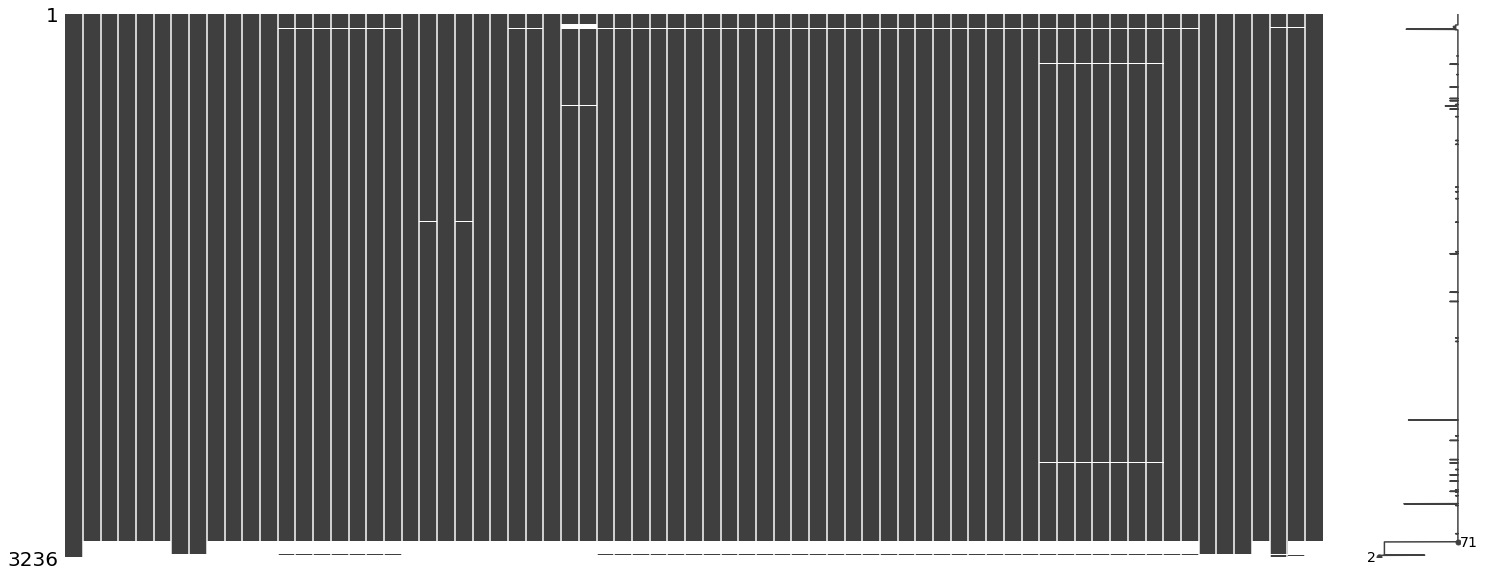

In [70]:
## Visualizng missing data
msno.matrix(df);

In [71]:
#### Removing data entries with nulls
## 1) 84 rows removed because only CDC diabetes data included Puerto Rico
## 2) 29 AK, 5 HI, 1 CO, 1 FL remaining rows removed because Natural Amenities Index didn't have data
## 3) 30 remaining rows removed because of Nulls in lowAccessInc_pct_15 or Food Desert 
## 4) 15 remaining rows removed because transportation data was missing

df_clean = df.dropna()
df_clean.reset_index(inplace=True, drop=True)

## Exporting to CSV

In [72]:
## Exporting the full CSV
df.to_csv('../data/exports/health_landscape.csv', index=False)

## Exporting the cleaned CSV
df_clean.to_csv('../data/exports/health_landscape_clean.csv', index=False)